In [8]:
# PARAMETERS (for papermill)

# Đường dẫn tới basket_bool được tạo từ Notebook 02
BASKET_BOOL_PATH = "c:/Users/hp/Documents/DataMining/Nhom-3/data/processed/basket_bool.parquet"

# Đường dẫn lưu file luật kết hợp sau khi lọc
RULES_OUTPUT_PATH = "c:/Users/hp/Documents/DataMining/Nhom-3/data/processed/rules_fpgrowth_filtered.csv"

# Tham số cho bước khai thác tập mục phổ biến (frequent itemsets)
MIN_SUPPORT = 0.01     # ngưỡng support tối thiểu
MAX_LEN = 3            # độ dài tối đa của itemset (số sản phẩm trong 1 tập)

# Tham số cho bước sinh luật
METRIC = "lift"        # chỉ số dùng để generate rules: 'support' / 'confidence' / 'lift'
MIN_THRESHOLD = 1.0    # ngưỡng tối thiểu cho METRIC

# Tham số lọc luật sau khi generate
FILTER_MIN_SUPPORT = 0.01
FILTER_MIN_CONF = 0.3
FILTER_MIN_LIFT = 1.2
FILTER_MAX_ANTECEDENTS = 2
FILTER_MAX_CONSEQUENTS = 1

# Số lượng luật top để vẽ biểu đồ
TOP_N_RULES = 20

# Bật/tắt các biểu đồ matplotlib
PLOT_TOP_LIFT = True
PLOT_TOP_CONF = True
PLOT_SCATTER = True
PLOT_NETWORK = True

# Bật/tắt biểu đồ HTML tương tác (Plotly)
PLOT_PLOTLY_SCATTER = True


## Set up

In [9]:
%load_ext autoreload
%autoreload 2

import os
import sys

# Determine correct project root
cwd = os.getcwd()
if os.path.basename(cwd) == "notebooks":
    project_root = os.path.abspath("..")
else:
    project_root = cwd

src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Biểu đồ tương tác HTML
import plotly.express as px

from apriori_library import FPGrowthMiner, DataVisualizer  # classes trong library của bạn


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Thiết lập style vẽ biểu đồ 

In [10]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12


In [11]:
# Khởi tạo DataVisualizer với style đã cấu hình
visualizer = DataVisualizer()

## Tải dữ liệu basket_bool

In [12]:
# Tải basket_bool
basket_bool = pd.read_parquet(BASKET_BOOL_PATH)

print("=== Thông tin basket_bool ===")
print(f"- Số hoá đơn (rows): {basket_bool.shape[0]:,}")
print(f"- Số sản phẩm (columns): {basket_bool.shape[1]:,}")
print(f"- Tỷ lệ ô = 1 (có mua): {basket_bool.values.mean():.4f}")

basket_bool.head()

=== Thông tin basket_bool ===
- Số hoá đơn (rows): 18,021
- Số sản phẩm (columns): 4,007
- Tỷ lệ ô = 1 (có mua): 0.0066


,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Khai thác tập mục phổ biến (FP-Growth)

In [13]:
# Khởi tạo FP-Growth miner
miner = FPGrowthMiner(basket_bool=basket_bool)

start_time = time.time()
frequent_itemsets_fp = miner.mine_frequent_itemsets(
    min_support=MIN_SUPPORT,
    max_len=MAX_LEN,
    use_colnames=True,
)
elapsed_time = time.time() - start_time

print("=== Kết quả khai thác tập mục phổ biến (FP-Growth) ===")
print(f"- Thời gian chạy: {elapsed_time:.2f} giây")
print(f"- Số tập mục phổ biến thu được: {len(frequent_itemsets_fp):,}")

frequent_itemsets_fp.head(10)

=== Kết quả khai thác tập mục phổ biến (FP-Growth) ===
- Thời gian chạy: 4.23 giây
- Số tập mục phổ biến thu được: 2,120


,support,itemsets
0,0.119971,(WHITE HANGING HEART T-LIGHT HOLDER)
84,0.107375,(JUMBO BAG RED RETROSPOT)
300,0.093502,(REGENCY CAKESTAND 3 TIER)
601,0.088397,(PARTY BUNTING)
29,0.077243,(LUNCH BAG RED RETROSPOT)
7,0.076078,(ASSORTED COLOUR BIRD ORNAMENT)
637,0.068864,(SET OF 3 CAKE TINS PANTRY DESIGN )
71,0.067643,(NATURAL SLATE HEART CHALKBOARD )
161,0.067477,(LUNCH BAG BLACK SKULL.)
72,0.064591,(HEART OF WICKER SMALL)


## Sinh luật kết hợp

In [14]:
# Sinh luật kết hợp từ frequent itemsets
rules_fp = miner.generate_rules(
    metric=METRIC,
    min_threshold=MIN_THRESHOLD,
)

print("=== Luật kết hợp ban đầu ===")
print(f"- Số luật: {len(rules_fp):,}")
print(f"- Top 5 luật theo lift:")

rules_fp.head()

=== Luật kết hợp ban đầu ===
- Số luật: 3,856
- Top 5 luật theo lift:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
2608,"(HERB MARKER PARSLEY, HERB MARKER ROSEMARY)",(HERB MARKER THYME),0.011487,0.012763,0.010932,0.951691,74.567045,1.0,0.010785,20.435808,0.998053,0.820833,0.951066,0.904106
2613,(HERB MARKER THYME),"(HERB MARKER PARSLEY, HERB MARKER ROSEMARY)",0.012763,0.011487,0.010932,0.856522,74.567045,1.0,0.010785,6.889639,0.999344,0.820833,0.854855,0.904106
3036,"(HERB MARKER MINT, HERB MARKER THYME)",(HERB MARKER ROSEMARY),0.011098,0.012818,0.010599,0.955000,74.502403,1.0,0.010456,21.937369,0.997650,0.795833,0.954416,0.890920
3037,(HERB MARKER ROSEMARY),"(HERB MARKER MINT, HERB MARKER THYME)",0.012818,0.011098,0.010599,0.826840,74.502403,1.0,0.010456,5.710908,0.999388,0.795833,0.824896,0.890920
3243,"(HERB MARKER MINT, HERB MARKER THYME)",(HERB MARKER PARSLEY),0.011098,0.012652,0.010432,0.940000,74.297105,1.0,0.010292,16.455802,0.997612,0.783333,0.939231,0.882281


## Lọc luật

In [15]:
# Lọc luật theo các ngưỡng
rules_filtered = miner.filter_rules(
    min_support=FILTER_MIN_SUPPORT,
    min_confidence=FILTER_MIN_CONF,
    min_lift=FILTER_MIN_LIFT,
    max_len_antecedents=FILTER_MAX_ANTECEDENTS,
    max_len_consequents=FILTER_MAX_CONSEQUENTS,
)

# Thêm cột dễ đọc
rules_filtered = miner.add_readable_rule_str()

print("=== Luật sau khi lọc ===")
print(f"- Số luật còn lại: {len(rules_filtered):,}")
print(f"- Top 10 luật theo lift:")

rules_filtered.head(10)

=== Luật sau khi lọc ===
- Số luật còn lại: 3,856
- Top 10 luật theo lift:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,antecedents_str,consequents_str,rule_str
2608,"(HERB MARKER PARSLEY, HERB MARKER ROSEMARY)",(HERB MARKER THYME),0.011487,0.012763,0.010932,0.951691,74.567045,1.0,0.010785,20.435808,0.998053,0.820833,0.951066,0.904106,"HERB MARKER PARSLEY, HERB MARKER ROSEMARY",HERB MARKER THYME,"HERB MARKER PARSLEY, HERB MARKER ROSEMARY → HE..."
2613,(HERB MARKER THYME),"(HERB MARKER PARSLEY, HERB MARKER ROSEMARY)",0.012763,0.011487,0.010932,0.856522,74.567045,1.0,0.010785,6.889639,0.999344,0.820833,0.854855,0.904106,HERB MARKER THYME,"HERB MARKER PARSLEY, HERB MARKER ROSEMARY","HERB MARKER THYME → HERB MARKER PARSLEY, HERB ..."
3036,"(HERB MARKER MINT, HERB MARKER THYME)",(HERB MARKER ROSEMARY),0.011098,0.012818,0.010599,0.955000,74.502403,1.0,0.010456,21.937369,0.997650,0.795833,0.954416,0.890920,"HERB MARKER MINT, HERB MARKER THYME",HERB MARKER ROSEMARY,"HERB MARKER MINT, HERB MARKER THYME → HERB MAR..."
3037,(HERB MARKER ROSEMARY),"(HERB MARKER MINT, HERB MARKER THYME)",0.012818,0.011098,0.010599,0.826840,74.502403,1.0,0.010456,5.710908,0.999388,0.795833,0.824896,0.890920,HERB MARKER ROSEMARY,"HERB MARKER MINT, HERB MARKER THYME","HERB MARKER ROSEMARY → HERB MARKER MINT, HERB ..."
3243,"(HERB MARKER MINT, HERB MARKER THYME)",(HERB MARKER PARSLEY),0.011098,0.012652,0.010432,0.940000,74.297105,1.0,0.010292,16.455802,0.997612,0.783333,0.939231,0.882281,"HERB MARKER MINT, HERB MARKER THYME",HERB MARKER PARSLEY,"HERB MARKER MINT, HERB MARKER THYME → HERB MAR..."
3246,(HERB MARKER PARSLEY),"(HERB MARKER MINT, HERB MARKER THYME)",0.012652,0.011098,0.010432,0.824561,74.297105,1.0,0.010292,5.636740,0.999182,0.783333,0.822593,0.882281,HERB MARKER PARSLEY,"HERB MARKER MINT, HERB MARKER THYME","HERB MARKER PARSLEY → HERB MARKER MINT, HERB M..."
2610,"(HERB MARKER PARSLEY, HERB MARKER THYME)",(HERB MARKER ROSEMARY),0.011487,0.012818,0.010932,0.951691,74.244244,1.0,0.010784,20.434660,0.997995,0.817427,0.951064,0.902252,"HERB MARKER PARSLEY, HERB MARKER THYME",HERB MARKER ROSEMARY,"HERB MARKER PARSLEY, HERB MARKER THYME → HERB ..."
2611,(HERB MARKER ROSEMARY),"(HERB MARKER PARSLEY, HERB MARKER THYME)",0.012818,0.011487,0.010932,0.852814,74.244244,1.0,0.010784,6.716076,0.999341,0.817427,0.851104,0.902252,HERB MARKER ROSEMARY,"HERB MARKER PARSLEY, HERB MARKER THYME","HERB MARKER ROSEMARY → HERB MARKER PARSLEY, HE..."
2843,"(HERB MARKER BASIL, HERB MARKER THYME)",(HERB MARKER ROSEMARY),0.011265,0.012818,0.010710,0.950739,74.169983,1.0,0.010565,20.039787,0.997757,0.800830,0.950099,0.893118,"HERB MARKER BASIL, HERB MARKER THYME",HERB MARKER ROSEMARY,"HERB MARKER BASIL, HERB MARKER THYME → HERB MA..."
2846,(HERB MARKER ROSEMARY),"(HERB MARKER BASIL, HERB MARKER THYME)",0.012818,0.011265,0.010710,0.835498,74.169983,1.0,0.010565,6.010470,0.999327,0.800830,0.833624,0.893118,HERB MARKER ROSEMARY,"HERB MARKER BASIL, HERB MARKER THYME","HERB MARKER ROSEMARY → HERB MARKER BASIL, HERB..."


## Lưu kết quả

In [16]:
# Lưu luật đã lọc
miner.save_rules(RULES_OUTPUT_PATH, rules_filtered)

Đã lưu luật vào: c:/Users/hp/Documents/DataMining/Nhom-3/data/processed/rules_fpgrowth_filtered.csv


## Trực quan hóa

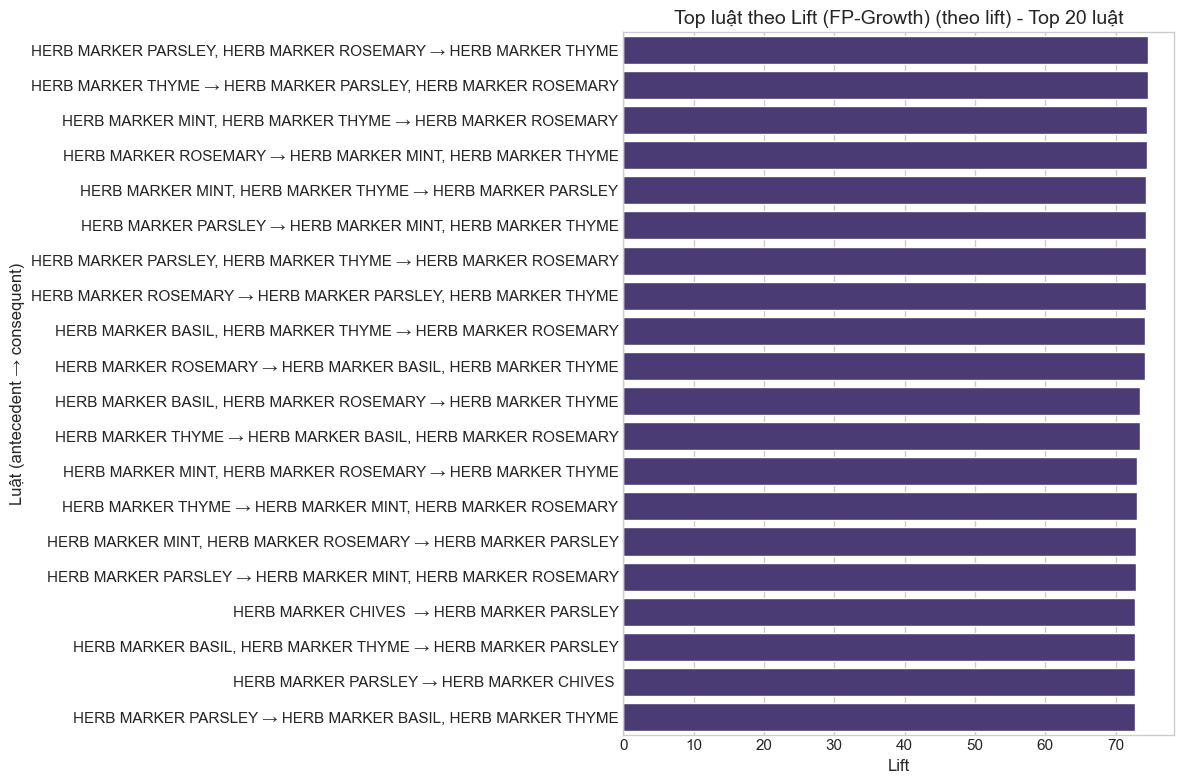

In [19]:
# Top rules by lift
if PLOT_TOP_LIFT:
    visualizer.plot_top_rules_lift(
        rules_filtered,
        top_n=TOP_N_RULES,
        title_prefix='Top luật theo Lift (FP-Growth)'
    )

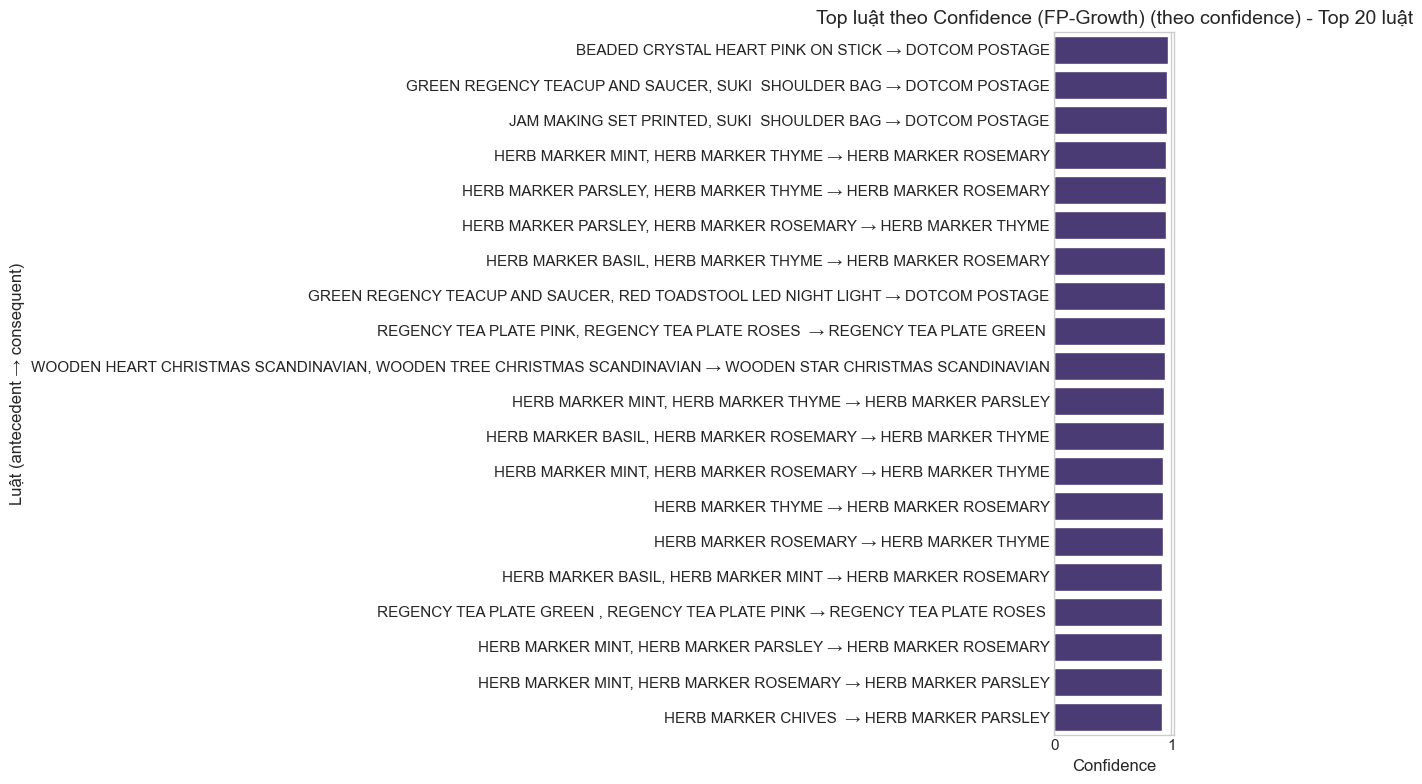

In [21]:
# Top rules by confidence
if PLOT_TOP_CONF:
    visualizer.plot_top_rules_confidence(
        rules_filtered,
        top_n=TOP_N_RULES,
        title_prefix='Top luật theo Confidence (FP-Growth)'
    )

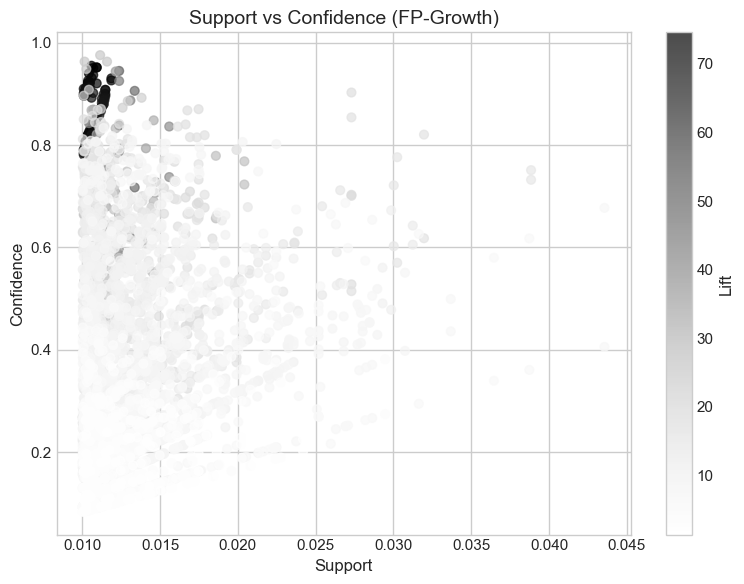

In [23]:
# Scatter plot
if PLOT_SCATTER:
    visualizer.plot_rules_support_confidence_scatter(
        rules_filtered,
        title='Support vs Confidence (FP-Growth)'
    )

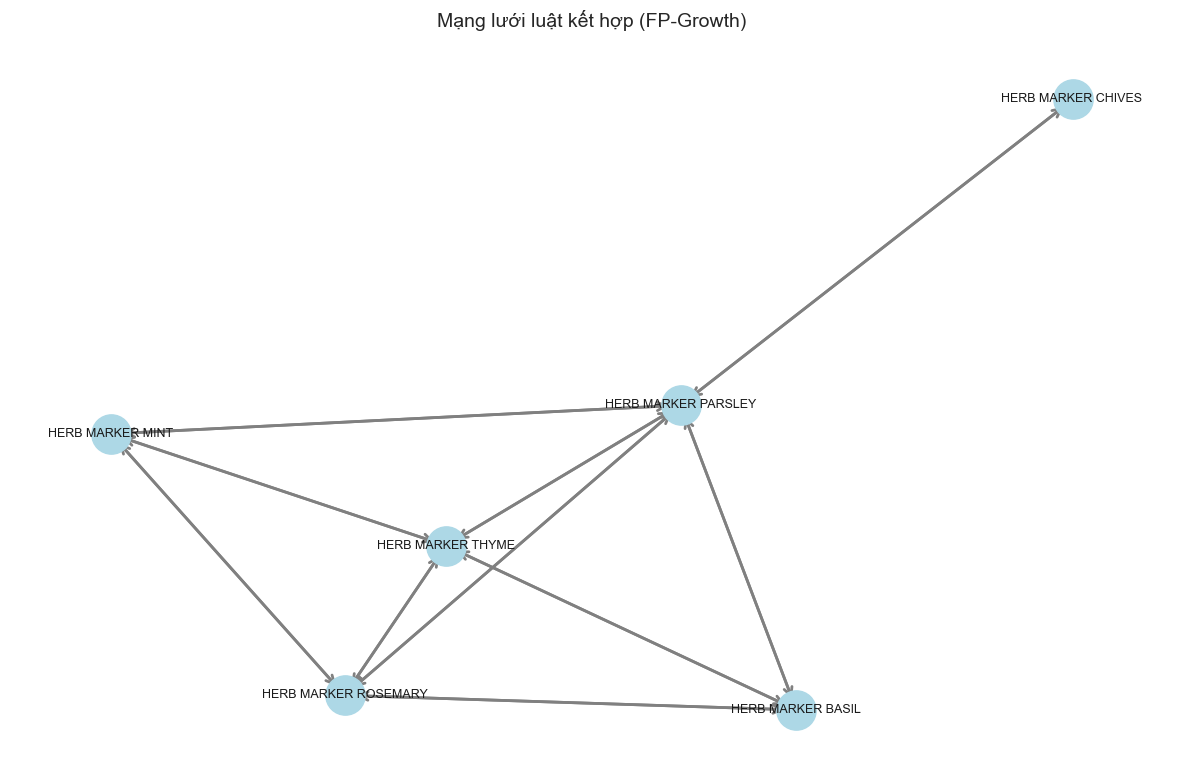

In [25]:
# Network graph
if PLOT_NETWORK:
    visualizer.plot_rules_network(
        rules_filtered,
        max_rules=TOP_N_RULES,
        title='Mạng lưới luật kết hợp (FP-Growth)'
    )

In [27]:
# Plotly scatter
if PLOT_PLOTLY_SCATTER:
    visualizer.plot_rules_support_confidence_scatter_interactive(
        rules_filtered,
        title='Support vs Confidence (FP-Growth)'
    )

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed